In [1]:
import numpy as np

from tqdm import tqdm
from matplotlib import pyplot as plt

import torch, numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt


SEED = 4200
torch.manual_seed(SEED)
np.random.seed(SEED)

torch.set_default_dtype(torch.float64)

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Matrix factorization through vanilla SCA

In [3]:
def MF_SCA(A, L, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9, max_iter = 200):
    m = A.shape[0]
    n = A.shape[1]

    V = np.ones((m,L)) 
    W = np.ones((L,n)) 

    # Let's also keep the Frobenius distances between the matrix A and its reconstruction VW
    
    D = np.zeros(max_iter)
    D[0] = np.linalg.norm(A - V @ W, ord = 'fro')
    
    for _ in tqdm(range(1, max_iter)):   

        # Local optimization step
        V_hat = A @ W.T @ np.linalg.inv(W @ W.T + lambda_v * np.eye(L))
        W_hat = np.linalg.inv(V.T @ V + lambda_w * np.eye(L)) @ V.T @ A   
        
        '''
        V_hat = (1 - lambda_v/np.max([lambda_v, np.linalg.norm(A @ np.linalg.pinv(W))])) @ A @ np.linalg.pinv(W)
        W_hat = (1 - lambda_w/np.max([lambda_v, np.linalg.norm(np.linalg.pinv(V) @ A)])) @ np.linalg.pinv(V) @ A
        '''

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v = eta_v * 0.99
        eta_w = eta_w * 0.99

        # Storing the reconstruction error
        D[_] = np.linalg.norm(A - V @ W, ord = 'fro')

    return (V,W), D

In [4]:
A = np.random.normal(size = (1500,2000))
A /= np.linalg.norm(A, axis = 0)
A = A * (A >= 0)
(V,W), D = MF_SCA(A,100)

100%|██████████| 199/199 [00:09<00:00, 20.51it/s]


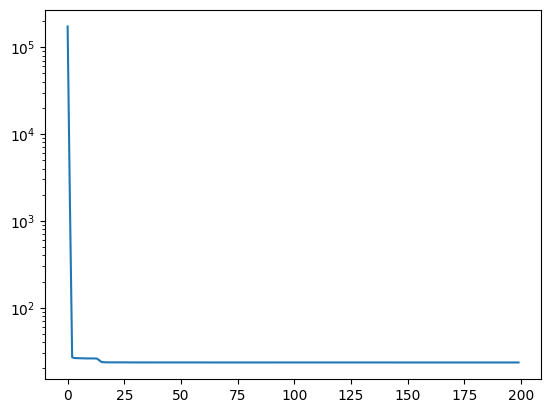

In [5]:
plt.plot(D)
plt.yscale('log')

In [6]:
np.linalg.norm(V @ W - A, ord='fro')

23.434543521304654

### Neural Building Blocks design - Deep Matrix Factorization

In [7]:
# Model for optimizing wrt V 

M = 400
N = 200
L = 15

A = torch.randn(M, N)
V = torch.randn(M, L)
W = torch.randn(L, N)

In [9]:
class ModuleV(nn.Module):
    def __init__(self, M, L, N, lambda_, t = 100):
        super().__init__()
        self.M = M
        self.L = L
        self.N = N
        
        self.t = t
        self.lambda_ = lambda_
        self.reset()
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=1, weight_decay = 3e-3)

    def forward(self, W):
        return self.V @ W
    
    def emit(self):
        return self.V

    def loss(self, A, W):
        return torch.linalg.norm(A - self.forward(W), 'fro') + self.lambda_ * torch.linalg.norm(self.forward(W), 'fro')

    def step(self, A, W):
        self.optimizer.zero_grad()
        loss_ = self.loss(A, W)
        loss_.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()
    
    def learn(self, A, W):
        for _ in range(self.t):
            self.step(A, W)

    def reset(self):
        self.V = nn.Parameter(torch.ones(self.M, self.L), requires_grad=True)


In [10]:
class ModuleW(nn.Module):
    def __init__(self, M, L, N, lambda_, t = 100):
        super().__init__()
        self.M = M
        self.L = L
        self.N = N
        
        self.t = t
        self.lambda_ = lambda_
        
        self.reset()
        self.optimizer = torch.optim.Adam(params=self.parameters(), lr=1, weight_decay = 3e-3)

    def forward(self, V):
        return V @ self.W
    
    def emit(self):
        return self.W
    
    def loss(self, A, V):
        return torch.linalg.norm(A - self.forward(V), 'fro') + self.lambda_ * torch.linalg.norm(self.forward(V), 'fro')
    
    def step(self, A, V):
        self.optimizer.zero_grad()
        loss_ = self.loss(A, V)
        loss_.backward(retain_graph=True)
        torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)
        self.optimizer.step()
    
    def learn(self, A, V):
        for _ in range(self.t):
            self.step(A, V)
    
    def reset(self):
        self.W = nn.Parameter(torch.ones(self.L, self.N), requires_grad=True)


In [11]:
class DeepMatrixFactorization(nn.Module):
    def __init__(self, M, L, N, lambda_ = 0.5, gamma = 0.99, T = 50, t = 100):

        self.M = M
        self.L = L
        self.N = N

        self.T = T
        self.t = t

        self.lambda_ = lambda_
        self.gamma = gamma

        self.blocks = []
        self.gammas = []

        for t in range(self.T):
            self.blocks.append({
                'Block V': ModuleV(self.M, self.L, self.N, self.lambda_, self.t),
                'Block W': ModuleW(self.M, self.L, self.N, self.lambda_, self.t)
            })

            self.gammas.append(self.gamma * (0.99 ** self.t))
        
        self.losses = []

    def inference(self, A): 
        
        V = torch.ones(self.M, self.L) 
        W = torch.ones(self.L, self.N) 

        self.losses.append((torch.linalg.norm(A - V @ W, 'fro')).detach().numpy())
        
        for t in tqdm(range(self.T)):
            
            self.blocks[t]['Block V'].learn(A, W)
            self.blocks[t]['Block W'].learn(A, V)

            V = V + self.gammas[t]*(self.blocks[t]['Block V'].emit() - V)
            W = W + self.gammas[t]*(self.blocks[t]['Block W'].emit() - W)

            self.blocks[t]['Block V'].reset()
            self.blocks[t]['Block W'].reset()

            self.losses.append((torch.linalg.norm(A - V @ W, 'fro')).detach().numpy())
        
        return V, W


In [16]:
model = DeepMatrixFactorization(M, L, N, lambda_ = 0.01)

In [17]:
V_, W_ = model.inference(A)

100%|██████████| 50/50 [00:35<00:00,  1.39it/s]


In [18]:
_, D2 = MF_SCA(A.detach().numpy(),L,max_iter=51)

100%|██████████| 50/50 [00:00<00:00, 543.52it/s]


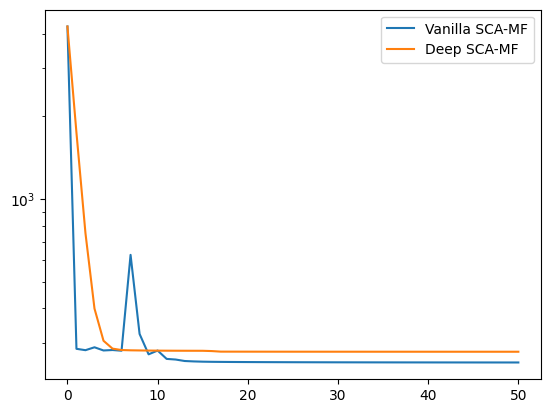

In [19]:
plt.plot(D2, label='Vanilla SCA-MF')
plt.plot(model.losses, label= 'Deep SCA-MF')
plt.yscale('log')
plt.legend()

__________

# Redesigning unrolled matrix factorization 

In [3]:
def NNMF_SCA(A, L, lambda_v = 0.1, lambda_w = 0.1, eta_v = 0.9, eta_w = 0.9, max_iter = 200):
    m = A.shape[0]
    n = A.shape[1]

    V = np.ones((m,L)) 
    W = np.ones((L,n)) 

    # Let's also keep the Frobenius distances between the matrix A and its reconstruction VW
    
    D = np.zeros(max_iter)
    D[0] = np.linalg.norm(A - V @ W, ord = 'fro')
    
    for _ in tqdm(range(1, max_iter)):   

        # Local optimization step
        V_hat = A @ W.T @ np.linalg.inv(W @ W.T + lambda_v * np.eye(L))
        V_hat = V_hat * (V_hat >= 0)

        W_hat = np.linalg.inv(V.T @ V + lambda_w * np.eye(L)) @ V.T @ A   
        W_hat = W_hat * (W_hat >= 0)
        
        '''
        V_hat = (1 - lambda_v/np.max([lambda_v, np.linalg.norm(A @ np.linalg.pinv(W))])) @ A @ np.linalg.pinv(W)
        W_hat = (1 - lambda_w/np.max([lambda_v, np.linalg.norm(np.linalg.pinv(V) @ A)])) @ np.linalg.pinv(V) @ A
        '''

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v = eta_v * 0.99
        eta_w = eta_w * 0.99

        # Storing the reconstruction error
        D[_] = np.linalg.norm(A - V @ W, ord = 'fro')

    return (V,W), D

In [4]:
A = np.random.normal(size = (150,2000))
A /= np.linalg.norm(A, axis = 0)
A = A * (A >= 0)

(V,W), D = NNMF_SCA(A,100)

  0%|          | 0/199 [00:00<?, ?it/s]

100%|██████████| 199/199 [00:03<00:00, 66.21it/s]


In [5]:
V

array([[2.10044670e-41, 2.42670326e-45, 2.09707772e-01, ...,
        6.06801852e-02, 2.78355638e-42, 1.54863710e-01],
       [1.34188241e-45, 1.00029170e-43, 3.24957903e-02, ...,
        6.90706650e-45, 2.44986752e-41, 5.93016532e-20],
       [2.45070647e-02, 7.25565818e-09, 4.77358017e-03, ...,
        2.59388290e-02, 1.64561092e-03, 9.17343208e-16],
       ...,
       [1.17604685e-30, 4.37862914e-03, 3.65455322e-45, ...,
        1.43213860e-01, 2.52031297e-18, 4.78104838e-02],
       [1.53146064e-02, 4.61426777e-02, 3.35447428e-15, ...,
        8.96510506e-04, 1.96226859e-02, 2.45675020e-02],
       [1.11049592e-02, 1.06251188e-02, 1.59424640e-02, ...,
        7.25606990e-06, 2.01114402e-02, 7.84704872e-04]])

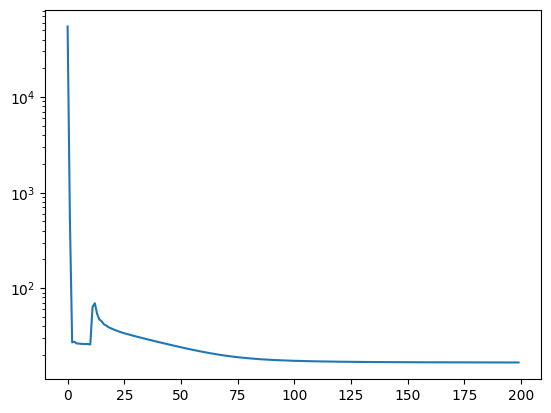

In [6]:
plt.plot(D)
plt.yscale('log')

In [99]:
class DNMF(nn.Module):
    def __init__(self, M, N, L, T = 10, gamma = 0.99):
        super(DNMF, self).__init__()

        # Matrix dimensions and latent factors
        self.M = M
        self.N = N
        self.L = L

        # Number of iterations
        self.T = T

        # Learnable parameters
        
        self.hV = nn.Parameter(torch.randn(L),requires_grad=True)
        self.hW = nn.Parameter(torch.randn(L),requires_grad=True)
        
        self.tauV = nn.Parameter(torch.ones(1),requires_grad=True)
        self.tauW = nn.Parameter(torch.ones(1),requires_grad=True)

        # Coefficient for convex combination
        self.gamma = gamma

        # Loss tracker
        self.loss = []
        
    def forward(self, A, loss_track = False):

        # Initialize V and W with the batch size in the first dimension
        V = torch.ones(A.shape[0], self.M, self.L)
        W = torch.ones(A.shape[0], self.L, self.N)

        for _ in range(self.T):

            # Compute V and W using batched matrix multiplication

            HV = torch.outer(self.hV, self.hV) + self.tauV ** 2 * torch.eye(self.L)
            HW = torch.outer(self.hW, self.hW) + self.tauW ** 2 * torch.eye(self.L)

            # Compute V and W using batched matrix multiplication
            V = (1 - self.gamma) * V + self.gamma * nn.functional.relu((A @ W.transpose(1, 2) @ HV[None, :, :]))
            W = (1 - self.gamma) * W + self.gamma * nn.functional.relu((HW[None, :, :] @ V.transpose(1, 2) @ A))

            # Update gamma
            self.gamma *= 0.99

            if loss_track:
                self.loss.append(torch.norm(A - torch.bmm(V, W), p='fro')/A.shape[0])

        self.gamma = 0.99
        return V, W
    
    '''
    def forward(self, A):

        # Initialize V and W with the batch size in the first dimension
        V = torch.ones(A.shape[0], self.M, self.L)
        W = torch.ones(A.shape[0], self.L, self.N)

        for _ in range(self.T):
            
            HV = torch.outer(self.hV, self.hV) + self.tauV * torch.eye(self.L)
            HW = torch.outer(self.hW, self.hW) + self.tauW * torch.eye(self.L)

            # Compute V and W using batched matrix multiplication
            V = (1 - self.gamma) * V + self.gamma * nn.functional.relu((A @ W.transpose(1, 2) @ HV[None, :, :]))
            W = (1 - self.gamma) * W + self.gamma * nn.functional.relu((HW[None, :, :] @ V.transpose(1, 2) @ A))

            # Update gamma
            self.gamma *= 0.99

        return V, W
    '''

In [91]:
class MatrixDataset():
    def __init__(self, M, N, size = 1000, batch_size = 256):
        
        self.M = M          # Number of samples in the original signal
        self.N = N          # Number of samples through the linear transformation

        self.size = size    # Size of the dataset
        self.batch_size = batch_size

        # Preallocation
        self.A = torch.zeros(self.size,self.M,self.N)

        # Generating the dataset
        self.set_data()


    def set_matrix(self, i):

        # Generating random sparsity in the canonic basis of the original signal
        A = torch.randn(self.M, self.N)
        A /= torch.linalg.norm(A, axis = 0)
        A = A * (A >= 0)
        self.A[i,:,:] = A


    def set_data(self):
        for i in range(self.size):
            self.set_matrix(i)
    
    
    def set_loader(self):
        return Data.DataLoader(dataset = Data.TensorDataset(self.A),
                               batch_size = self.batch_size,
                               shuffle = True)

In [100]:
# Dimensions for the matrices
m_ = 150
n_ = 200

# Building a training set and a test set 
train_set = MatrixDataset(m_, n_, size = 800).set_loader()
test_set = MatrixDataset(m_, n_, size = 200).set_loader()

In [106]:
def train(model, train_loader, valid_loader, num_epochs=50):

    # Initialization
    optimizer = torch.optim.SGD(
        model.parameters(),
        lr=1e-01,
        momentum=0.9,
        weight_decay=0,
    )
    scheduler = torch.optim.lr_scheduler.StepLR(
        optimizer, step_size=50, gamma=0.1
    )

    loss_train = np.zeros((num_epochs,))
    loss_test = np.zeros((num_epochs,))
    
    # Main loop

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for A in enumerate(train_loader):
            V, W = model.forward(A[1][0])
            loss = F.mse_loss(torch.bmm(V,W), A[1][0], reduction="sum")
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            model.zero_grad()
            train_loss += loss.data.item()
        loss_train[epoch] = train_loss / len(train_loader.dataset)
        scheduler.step()

        # validation
        model.eval()
        test_loss = 0
        for A in enumerate(valid_loader):
            V, W = model.forward(A[1][0])
            test_loss += F.mse_loss(torch.bmm(V,W), A[1][0], reduction="sum").data.item()
        loss_test[epoch] = test_loss / len(valid_loader.dataset)
        
        # Print
        if epoch % 10 == 0:
            print(
                "Epoch %d, Train loss %.8f, Validation loss %.8f"
                % (epoch, loss_train[epoch], loss_test[epoch])
            )

    return loss_test

In [102]:
model = DNMF(m_, n_, 20)

In [103]:
model.gamma

0.99

In [108]:
[p for p in list(model.parameters()) if p.is_leaf]

[Parameter containing:
 tensor([1.3590e-01, 1.5661e-01, 1.5481e-01, 1.2766e-01, 6.3730e-01, 5.9731e-02,
         1.2047e-01, 4.8991e-01, 1.4565e-01, 1.4551e-01, 5.1586e-02, 1.7439e-02,
         1.3281e-01, 2.8497e-04, 1.4031e-01, 6.4182e-02, 8.5476e-02, 1.3126e-01,
         2.1675e-01, 1.4447e-01], requires_grad=True),
 Parameter containing:
 tensor([-0.0942,  0.0692, -0.1136, -0.0339,  0.1406,  0.1367,  0.2212, -0.0911,
          0.0329, -0.0097,  0.1642,  0.0596, -0.0748,  0.1066, -0.0152,  0.1148,
         -0.0428, -0.0310, -0.1471,  0.0116], requires_grad=True),
 Parameter containing:
 tensor([0.0020], requires_grad=True),
 Parameter containing:
 tensor([-0.0010], requires_grad=True)]

In [ ]:
train(model, train_set, test_set)

In [109]:
import torch.nn.functional as F

def NNMF_SCA_BATCH(A, L, lambda_v=0.1, lambda_w=0.1, eta_v=0.9, eta_w=0.9, max_iter=40):
    device = A.device  # Ensure operations are performed on the same device as input
    batch_size, m, n = A.shape

    V = torch.ones((batch_size, m, L), device=device)
    W = torch.ones((batch_size, L, n), device=device)

    # Frobenius distances for each iteration
    D = torch.zeros(max_iter, device=device)
    D[0] = torch.norm(A - torch.bmm(V, W), p='fro')

    for it in tqdm(range(1, max_iter)):
        # Local optimization step
        WWT_inv = torch.linalg.inv(torch.bmm(W, W.transpose(1, 2)) + lambda_v * torch.eye(L, device=device).unsqueeze(0))
        V_hat = torch.bmm(torch.bmm(A, W.transpose(1, 2)), WWT_inv)
        V_hat = torch.relu(V_hat)  # Ensure non-negativity

        VTV_inv = torch.linalg.inv(torch.bmm(V.transpose(1, 2), V) + lambda_w * torch.eye(L, device=device).unsqueeze(0))
        W_hat = torch.bmm(VTV_inv, torch.bmm(V.transpose(1, 2), A))
        W_hat = torch.relu(W_hat)  # Ensure non-negativity

        # Global smoothing step
        V = V + eta_v * (V_hat - V)
        W = W + eta_w * (W_hat - W)

        # Decreasing stepsize
        eta_v *= 0.99
        eta_w *= 0.99

        # Storing the reconstruction error
        D[it] = torch.norm(A - torch.bmm(V, W), p='fro')/A.shape[0]

    return (V, W), D

In [49]:
model.gamma = 0.99 
model.loss = []

In [110]:
A = torch.randn(256, 150, 200) 
A /= torch.linalg.norm(A, axis = 0)
A = A * (A >= 0)

(V, W), D = NNMF_SCA_BATCH(A, L=20)

V,W = model.forward(A, True)

100%|██████████| 39/39 [00:02<00:00, 19.42it/s]


In [111]:
W

tensor([[[2.8989e-14, 2.8989e-14, 2.8989e-14,  ..., 2.8989e-14,
          2.8989e-14, 2.8989e-14],
         [1.0731e-08, 9.4271e-09, 1.0187e-08,  ..., 7.9210e-09,
          8.7165e-09, 9.4188e-09],
         [2.8989e-14, 2.8989e-14, 2.8989e-14,  ..., 2.8989e-14,
          2.8989e-14, 2.8989e-14],
         ...,
         [2.8989e-14, 2.8989e-14, 2.8989e-14,  ..., 2.8989e-14,
          2.8989e-14, 2.8989e-14],
         [2.8989e-14, 2.8989e-14, 2.8989e-14,  ..., 2.8989e-14,
          2.8989e-14, 2.8989e-14],
         [1.7917e-09, 1.5739e-09, 1.7007e-09,  ..., 1.3225e-09,
          1.4553e-09, 1.5725e-09]],

        [[2.8989e-14, 2.8989e-14, 2.8989e-14,  ..., 2.8989e-14,
          2.8989e-14, 2.8989e-14],
         [1.1008e-08, 8.5883e-09, 1.1938e-08,  ..., 9.9219e-09,
          8.9382e-09, 1.1056e-08],
         [2.8989e-14, 2.8989e-14, 2.8989e-14,  ..., 2.8989e-14,
          2.8989e-14, 2.8989e-14],
         ...,
         [2.8989e-14, 2.8989e-14, 2.8989e-14,  ..., 2.8989e-14,
          2.898

In [112]:
D

tensor([5.5357e+04, 1.9833e+00, 4.2731e-01, 4.7825e-01, 4.0569e-01, 4.0404e-01,
        3.9641e-01, 3.9386e-01, 3.9344e-01, 3.9250e-01, 3.9269e-01, 3.9240e-01,
        3.9251e-01, 3.9243e-01, 3.9246e-01, 3.9220e-01, 3.8778e-01, 3.9184e-01,
        3.9820e-01, 3.8624e-01, 3.7361e-01, 3.6590e-01, 3.6089e-01, 3.5784e-01,
        3.5595e-01, 3.5471e-01, 3.5382e-01, 3.5312e-01, 3.5253e-01, 3.5203e-01,
        3.5158e-01, 3.5118e-01, 3.5082e-01, 3.5049e-01, 3.5018e-01, 3.4991e-01,
        3.4965e-01, 3.4941e-01, 3.4919e-01, 3.4898e-01])

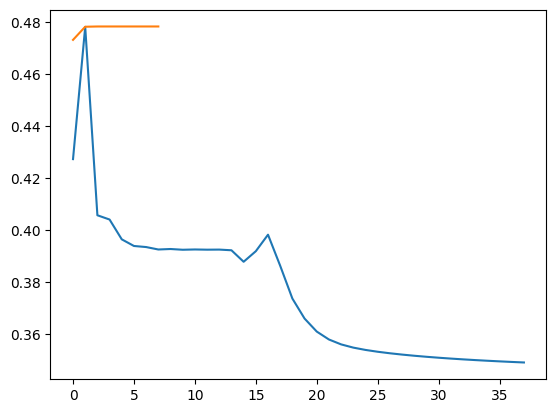

In [115]:
plt.plot(D[2:])
plt.plot([L.detach().numpy() for L in model.loss][2:])

In [114]:
model.loss

[tensor(47.2360, grad_fn=<DivBackward0>),
 tensor(0.4991, grad_fn=<DivBackward0>),
 tensor(0.4732, grad_fn=<DivBackward0>),
 tensor(0.4783, grad_fn=<DivBackward0>),
 tensor(0.4784, grad_fn=<DivBackward0>),
 tensor(0.4784, grad_fn=<DivBackward0>),
 tensor(0.4784, grad_fn=<DivBackward0>),
 tensor(0.4784, grad_fn=<DivBackward0>),
 tensor(0.4784, grad_fn=<DivBackward0>),
 tensor(0.4784, grad_fn=<DivBackward0>)]

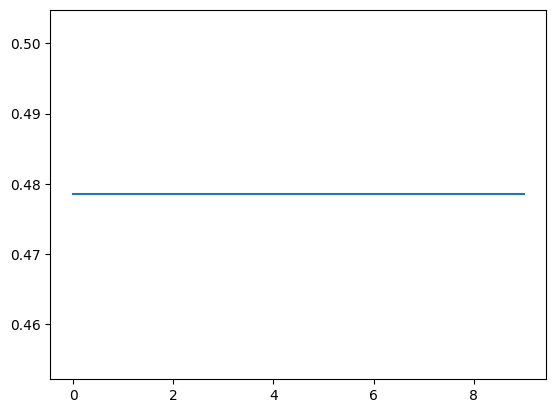

In [39]:
plt.plot([L.detach().numpy() for L in model.loss])